In [1]:
from statistics import mean
import seaborn as sns
import networkx as nx
import pandas as pd
import time
import datetime
import freeman as fm
import operator
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import scipy

Carregamento das bases de dados

In [2]:
data = pd.read_csv('bill/hotStuff.csv')

In [3]:
data2 = pd.read_excel('bill/hot100.xlsx')

In [4]:
data2.columns

Index(['SongID', 'Performer', 'Song', 'spotify_genre', 'spotify_track_id',
       'spotify_track_preview_url', 'spotify_track_album',
       'spotify_track_explicit', 'spotify_track_duration_ms',
       'spotify_track_popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

In [5]:
def filtro(musica):
    new = musica.replace("#","")
    new = new.replace('"',"")
    new = new.replace("'","")
    new=new.replace("(","")
    new=new.replace(")","")
    new=new.replace("[","")
    new=new.replace("]","")
    new=new.replace("ç","c")
    new=new.replace("é","e")
    new=new.replace("ñ","n")
    new=new.replace("ò","o")
    new=new.replace("¿","?")
    new=new.replace("ó","o")
    new=new.replace("á","a")
    new=new.replace("ö","o")
    new=new.replace("Ó","O")
    new=new.replace("à","a")
    new=new.replace("�","?")
    
    
    return new

In [6]:
def sum100(number):
    return 100-number

In [7]:
def inv(number):
    return 1/number

In [8]:
def log(number):
    return np.log(number)

In [9]:
def loginv(number):
    return (1/(np.log(number)+1))

In [10]:
dic_func={sum100:"sum100",
          inv:"inv",
          log:"log",
          loginv:"loginv"}

In [11]:
l_drop=['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness']

In [12]:
def variaveis(dataf, year):
    dataframe=dataf[year].copy()
    
    def go_to_apply (dici,row):
        return dici[row['SongID']]

    for i in dic_func:
        name=dic_func[i]
        func=i
        dic={}
        for i in dataframe.index:
            print(dataframe["SongID"][i])
            if (dataframe["SongID"][i]) in dic:
                print("foi")
                dic[dataframe["SongID"][i]] += func(dataframe["Week Position"][i])
            else:
                print("nao")
                dic[dataframe["SongID"][i]] = func(dataframe["Week Position"][i])
        
        dataframe[name] = dataframe.apply (lambda row: go_to_apply(dic, row), axis=1)
    print(dataframe.columns)
        
    dataframe.drop_duplicates(subset="SongID", keep="last", inplace=True)
    
    dataframe=dataframe.reset_index(drop=True)
    return dataframe

In [13]:
# for i in dic_func:
#     variaveis(i,dic_func[i])    USAR DEPOIS

In [14]:
def diats(row):
    return pd.Timestamp(row["WeekID"])

In [15]:
data['timestamp']=data.apply (lambda row: diats(row), axis=1)

In [16]:
def musica_filtrada (row):
   return filtro(row['SongID'])

In [17]:
data2['SongFiltred']=data2.apply (lambda row: musica_filtrada(row), axis=1)

In [18]:
data.columns

Index(['url', 'WeekID', 'Week Position', 'Song', 'Performer', 'SongID',
       'Instance', 'Previous Week Position', 'Peak Position', 'Weeks on Chart',
       'timestamp'],
      dtype='object')

In [19]:
dic_anos={}
for ano in range(2000,2020):
    v1="1/1/{0}".format(ano)
    v2 = "1/1/{0}".format(ano+1)
    dic_anos[ano]=[v1,v2]
    
print(dic_anos)

{2000: ['1/1/2000', '1/1/2001'], 2001: ['1/1/2001', '1/1/2002'], 2002: ['1/1/2002', '1/1/2003'], 2003: ['1/1/2003', '1/1/2004'], 2004: ['1/1/2004', '1/1/2005'], 2005: ['1/1/2005', '1/1/2006'], 2006: ['1/1/2006', '1/1/2007'], 2007: ['1/1/2007', '1/1/2008'], 2008: ['1/1/2008', '1/1/2009'], 2009: ['1/1/2009', '1/1/2010'], 2010: ['1/1/2010', '1/1/2011'], 2011: ['1/1/2011', '1/1/2012'], 2012: ['1/1/2012', '1/1/2013'], 2013: ['1/1/2013', '1/1/2014'], 2014: ['1/1/2014', '1/1/2015'], 2015: ['1/1/2015', '1/1/2016'], 2016: ['1/1/2016', '1/1/2017'], 2017: ['1/1/2017', '1/1/2018'], 2018: ['1/1/2018', '1/1/2019'], 2019: ['1/1/2019', '1/1/2020']}


In [20]:
data.tail()

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart,timestamp
320490,https://www.billboard.com/charts/hot-100/2019-...,1/5/2019,8,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,7,13.0,8,25,2019-01-05
320491,https://www.billboard.com/charts/hot-100/2019-...,12/7/2019,47,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,NaN,47,26,2019-12-07
320492,https://www.billboard.com/charts/hot-100/2019-...,12/14/2019,23,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,47.0,23,27,2019-12-14
320493,https://www.billboard.com/charts/hot-100/2019-...,12/21/2019,15,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,23.0,15,28,2019-12-21
320494,https://www.billboard.com/charts/hot-100/2019-...,12/28/2019,9,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,8,15.0,9,29,2019-12-28


In [21]:
datamerge = pd.merge(data,data2,on='SongID')
l_drop=['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness','spotify_genre']

for i in l_drop:
    dl=datamerge.dropna(axis=0, how="all", subset=[i], inplace=False)
    datamerge=dl
datah=datamerge.copy()
indexNames = datah[datah["spotify_genre"] == "[]" ].index
datah.drop(indexNames , inplace=True, axis=0)
dataframe=datah
dataframe.drop_duplicates(subset='SongID', keep='first', inplace=True)
dataframe=dataframe.reset_index(drop=True)

In [22]:
dic_dataframe={}
for i in (dic_anos):
    dic_dataframe[i] = dataframe[(dataframe["timestamp"]>=pd.Timestamp(dic_anos[i][0])) & (dataframe["timestamp"]<=pd.Timestamp(dic_anos[i][1]))]

In [23]:
dataframe

,url,WeekID,Week Position,Song_x,Performer_x,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,SongFiltred
0,https://www.billboard.com/charts/hot-100/2019-...,2/2/2019,1,7 Rings,Ariana Grande,7 RingsAriana Grande,1,NaN,1,1,...,-10.732,0.0,0.3340,0.59200,0.000000,0.0881,0.327,140.048,4.0,7 RingsAriana Grande
1,https://www.billboard.com/charts/hot-100/2019-...,3/16/2019,1,Sucker,Jonas Brothers,SuckerJonas Brothers,1,NaN,1,1,...,-5.065,0.0,0.0588,0.04270,0.000000,0.1060,0.952,137.958,4.0,SuckerJonas Brothers
2,https://www.billboard.com/charts/hot-100/2019-...,2/23/2019,2,"Break Up With Your Girlfriend, I'm Bored",Ariana Grande,"Break Up With Your Girlfriend, I'm BoredAriana...",1,NaN,2,1,...,-5.290,0.0,0.0917,0.04210,0.000000,0.1060,0.335,169.999,4.0,"Break Up With Your Girlfriend, Im BoredAriana ..."
3,https://www.billboard.com/charts/hot-100/2019-...,7/6/2019,2,Senorita,Shawn Mendes & Camila Cabello,SenoritaShawn Mendes & Camila Cabello,1,NaN,2,1,...,-6.039,0.0,0.0287,0.03700,0.000000,0.0945,0.750,116.947,4.0,SenoritaShawn Mendes & Camila Cabello
4,https://www.billboard.com/charts/hot-100/2018-...,8/18/2018,4,Sicko Mode,Travis Scott,Sicko ModeTravis Scott,1,NaN,4,1,...,-3.714,1.0,0.2220,0.00513,0.000000,0.1240,0.446,155.008,4.0,Sicko ModeTravis Scott
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22015,http://www.billboard.com/charts/hot-100/2000-0...,6/3/2000,71,What'Chu Like,Da Brat Featuring Tyrese,What'Chu LikeDa Brat Featuring Tyrese,1,NaN,71,1,...,-8.951,0.0,0.2400,0.01700,0.000000,0.0669,0.817,99.974,4.0,WhatChu LikeDa Brat Featuring Tyrese
22016,http://www.billboard.com/charts/hot-100/1972-0...,4/8/1972,83,What'd I Say,Rare Earth,What'd I SayRare Earth,1,NaN,83,1,...,-8.682,1.0,0.2090,0.25300,0.001610,0.3160,0.750,182.397,4.0,Whatd I SayRare Earth
22017,http://www.billboard.com/charts/hot-100/1999-0...,4/3/1999,98,What'd You Come Here For?,Trina & Tamara,What'd You Come Here For?Trina & Tamara,1,NaN,98,1,...,-3.643,1.0,0.0719,0.05080,0.001230,0.0580,0.759,102.907,4.0,Whatd You Come Here For?Trina & Tamara
22018,http://www.billboard.com/charts/hot-100/2005-0...,2/26/2005,100,What's A Guy Gotta Do,Joe Nichols,What's A Guy Gotta DoJoe Nichols,1,NaN,100,1,...,-3.808,1.0,0.0770,0.66200,0.000031,0.0746,0.920,170.224,4.0,Whats A Guy Gotta DoJoe Nichols


Função para checar se a string está na tabela ascii

Filtro aplicado no songid

Dicionário dos SongIDs e as respectivas semanas na Bilboard

Filtro aplicado no nome das músicas

In [24]:
import re

dic_bugs={
    "Lil Nas &":"Lil Nas X",
    "& Ambassadors":"X Ambassadors",
    "Mia &":"Mia X",
    "for KING & COUNTRY":"for KING and COUNTRY",
    "Brooks & Dunn":"Brooks and Dunn"   
}

feat="Featuring"
def parse(nomes):
    
    new_nomes=nomes.replace("(","")
    new_nomes=new_nomes.replace(")","")
    new_nomes=new_nomes.replace("[","")
    new_nomes=new_nomes.replace("]","")
    new_nomes=new_nomes.replace("'","")
    new_nomes=new_nomes.replace('"',"")
    new_nomes=new_nomes.replace(", "," & ")
    new_nomes=new_nomes.replace("Featuring","&")
    new_nomes=new_nomes.replace("Feat.","&")
    new_nomes=new_nomes.replace(" Or "," & ")
    new_nomes=new_nomes.replace(" X "," & ")
    new_nomes=new_nomes.replace(" x "," & ")
    for i in dic_bugs:
        if i in new_nomes:
            new_nomes=new_nomes.replace(i,dic_bugs[i])
    return re.split(r'\s[,&+]\s', new_nomes)

In [25]:
def insertfeat(lista_mc,lista,songid):
    
    for i in lista:
        if [songid,i] not in lista_mc:
            lista_mc.append([songid,i])

In [26]:
lista_musicas={}
for i in dic_dataframe:
    lista=[]
    for j in dic_dataframe[i].index:
        if dic_dataframe[i]['SongFiltred'][j] not in lista:
            lista.append(dic_dataframe[i]['SongFiltred'][j])
    lista_musicas[i]=lista

In [27]:
def conv_string_to_list(string):
    new=string.replace("'","")
    new=new.replace('"',"")
    new=new.strip('][').split(', ')
    return new

In [28]:
lista_cantores={}
lista_participacao={}
lista_generos={}
dic_SongID_Performers={}
lista_musicas_generos={}

for i in dic_dataframe:
    lista_s=[]
    lista_p=[]
    lista_g=[]
    lista_mg=[]
    
    for j in dic_dataframe[i].index:
        lista_singers = parse(dic_dataframe[i]["Performer_x"][j])
        for k in lista_singers:
            if k not in lista_s:
                lista_s.append(k)
                
        if len(lista_singers)>1:
            insertfeat(lista_p,lista_singers,dic_dataframe[i]["SongFiltred"][j])  
        print(dic_dataframe[i]["spotify_genre"][j],j)
        gen=conv_string_to_list(dic_dataframe[i]["spotify_genre"][j])
        
    
        for k in range(len(gen)):
            if gen[k] not in lista_g:
                lista_g.append(gen[k])
            lista_mg.append([dic_dataframe[i]["SongFiltred"][j],gen[k]])
    
    lista_musicas_generos[i]=lista_mg
    lista_generos[i]=lista_g
    lista_cantores[i]=lista_s
    lista_participacao[i]=lista_p

['dance pop', 'pop'] 119
['dance pop', 'latin', 'latin pop', 'mexican pop', 'puerto rican pop'] 234
['urban contemporary'] 335
['country'] 389
['dance pop', 'pop', 'r&b', 'urban contemporary'] 643
['crunk', 'dirty south rap', 'gangster rap', 'new orleans rap'] 1125
['dance pop', 'girl group', 'hip pop', 'pop', 'pop rap', 'r&b', 'urban contemporary'] 1145
['neo mellow', 'pop rock', 'post-grunge'] 1174
['hip pop', 'neo soul', 'r&b', 'urban contemporary'] 1196
['contemporary country', 'country', 'country road', 'modern country rock'] 1202
['country', 'country dawn', 'dance pop', 'pop rock'] 1220
['album rock', 'art rock', 'classic rock', 'folk', 'folk rock', 'heartland rock', 'mellow gold', 'new wave pop', 'pop rock', 'rock', 'roots rock', 'singer-songwriter', 'soft rock', 'yacht rock'] 1249
['dance pop', 'latin', 'latin pop', 'mexican pop', 'pop', 'tropical'] 1255
['dance pop', 'girl group', 'hip pop', 'pop', 'pop rap', 'r&b', 'urban contemporary'] 1256
['contemporary country', 'country'

['alternative rock', 'pop rock', 'post-grunge'] 9781
['dance pop', 'east coast hip hop', 'gangster rap', 'hip hop', 'hip pop', 'pop rap', 'queens hip hop', 'rap', 'urban contemporary'] 9782
['alternative metal', 'nu metal', 'post-grunge', 'rap metal'] 9783
['alternative metal', 'nu metal', 'post-grunge', 'rap rock', 'rock'] 9968
['contemporary country', 'country', 'country dawn', 'country road', 'pop rock'] 10159
['contemporary country', 'country', 'country dawn', 'country road'] 10160
['g funk', 'gangster rap', 'hip hop', 'rap', 'west coast rap'] 10161
['dance pop', 'hip hop', 'hip pop', 'philly rap', 'pop rap', 'r&b', 'rap', 'urban contemporary'] 10162
['eurodance', 'europop', 'finnish edm'] 10414
['alternative metal', 'funk metal', 'nu metal', 'post-grunge', 'rap metal', 'wrestling'] 10600
['contemporary country', 'country', 'country dawn', 'country road'] 10601
['contemporary country', 'country', 'country dawn', 'oklahoma country'] 10602
['hip pop'] 10839
['dance pop', 'hip pop', '

['bronx hip hop', 'east coast hip hop', 'gangster rap', 'hardcore hip hop', 'hip hop', 'hip pop', 'pop rap', 'rap', 'trap'] 15352
['dance pop', 'pop', 'post-teen pop'] 15807
['canadian pop', 'neo soul'] 15928
['folk', 'lilith', 'mellow gold', 'neo mellow', 'new wave pop', 'permanent wave', 'pop rock', 'rock'] 16335
['atl hip hop', 'crunk', 'dirty south rap', 'gangster rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] 16336
['chicano rap', 'latin hip hop'] 16496
['dance pop', 'hip hop', 'hip pop', 'neo soul', 'new jack swing', 'quiet storm', 'r&b', 'urban contemporary'] 16497
['dance pop', 'latin', 'latin arena pop', 'latin pop', 'mexican pop'] 16535
['contemporary country', 'country', 'country road', 'modern country rock'] 16538
['alternative metal', 'christian rock', 'industrial metal', 'nu metal', 'post-grunge', 'rap rock', 'rock'] 16612
['heartland rock', 'mellow gold', 'permanent wave', 'rock', 'singer-songwriter'] 16628
['gangster rap', 'hip hop', 'hyphy', 'rap', 'west coast rap

['australian dance', 'australian pop', 'dance pop', 'electropop', 'eurodance', 'europop', 'new wave pop', 'pop'] 10349
['bronx hip hop', 'east coast hip hop', 'gangster rap', 'hardcore hip hop', 'hip hop', 'hip pop', 'pop rap', 'rap', 'trap'] 10376
['dance pop', 'deep pop r&b', 'hip pop', 'neo soul', 'pop', 'pop rap', 'r&b', 'rap', 'urban contemporary'] 10607
['dance pop', 'dancehall', 'pop', 'pop rap'] 10841
['boy band', 'dance pop', 'hip pop', 'pop rap', 'r&b', 'southern hip hop', 'urban contemporary'] 10842
['adult standards', 'folk', 'lilith', 'vocal jazz'] 10843
['hip pop', 'neo soul', 'new jack swing', 'quiet storm', 'r&b', 'urban contemporary'] 11097
['contemporary country', 'country', 'country road', 'oklahoma country'] 11576
['country', 'country road'] 11852
['atl hip hop', 'boy band', 'dance pop', 'gangster rap', 'hip pop', 'new jack swing', 'pop rap', 'r&b', 'rap', 'southern hip hop', 'urban contemporary'] 11853
['chicago rap', 'hip hop', 'hip pop', 'new jack swing', 'r&b', 

['contemporary country', 'country', 'country dawn', 'country road'] 8537
['contemporary country', 'country', 'country road'] 8538
['east coast hip hop', 'hardcore hip hop', 'hip hop', 'hip pop', 'old school hip hop', 'pop rap', 'queens hip hop', 'r&b', 'rap', 'southern hip hop', 'urban contemporary'] 8539
['alternative metal', 'post-grunge'] 8631
['pop punk', 'punk', 'socal pop punk'] 8632
['detroit hip hop', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'rap rock', 'southern hip hop'] 8633
['canadian pop', 'candy pop', 'dance pop', 'pop', 'post-teen pop'] 8634
['contemporary country', 'country', 'country road'] 8635
['alternative metal', 'alternative rock', 'modern rock', 'nu metal', 'permanent wave', 'post-grunge', 'rock'] 8737
['contemporary country', 'country', 'country road'] 8738
['contemporary country', 'country', 'country road', 'modern country rock'] 8739
['contemporary country', 'country', 'country road'] 8740
['hip hop', 'new orleans rap', 'pop rap', 'rap', 'trap'] 8741
['gan

['dance pop', 'hip pop', 'pop', 'pop rap', 'post-teen pop', 'r&b', 'rap', 'urban contemporary'] 9282
['g funk', 'gangster rap', 'hip hop', 'rap', 'west coast rap'] 9432
['contemporary country', 'country', 'country road', 'country rock', 'modern country rock', 'redneck'] 9433
['permanent wave', 'pop'] 9627
['acoustic pop', 'neo mellow', 'pop rock', 'post-grunge'] 9794
['dance pop', 'post-teen pop'] 9795
['dance pop', 'pop', 'pop rap', 'post-teen pop', 'urban contemporary'] 9973
['adult standards', 'lounge', 'mellow gold', 'motown', 'quiet storm', 'soft rock', 'soul', 'vocal jazz'] 10164
['dance pop', 'europop', 'hip pop', 'pop', 'pop rock', 'post-teen pop'] 10165
['dance pop', 'pop', 'pop rap'] 10291
['contemporary country', 'country', 'country road', 'country rock'] 10303
['dance pop', 'deep pop r&b', 'hip pop', 'new jack swing', 'pop rap', 'r&b', 'urban contemporary'] 10317
['contemporary country', 'country', 'country road', 'country rock'] 10845
['atl hip hop', 'dance pop', 'dirty so

['alternative metal', 'neo mellow', 'pop rock', 'post-grunge'] 19368
['contemporary country', 'country', 'country road'] 19679
['neo mellow', 'pop', 'pop rock'] 19707
['contemporary country', 'country', 'country road'] 19725
['contemporary country', 'country', 'country road'] 19949
['detroit hip hop', 'g funk', 'hip hop', 'rap'] 19976
['idol'] 20051
['blues rock', 'modern blues'] 20212
['contemporary country', 'country', 'country road'] 20261
['alternative dance', 'alternative rock', 'dance pop', 'electronic rock', 'lilith', 'permanent wave', 'pop rock', 'post-grunge', 'rock'] 20319
['east coast hip hop', 'gangster rap', 'hip hop', 'pop rap', 'queens hip hop', 'rap'] 20426
['dance pop', 'deep pop r&b', 'hip hop', 'hip pop', 'miami hip hop', 'pop rap', 'r&b', 'rap', 'southern hip hop', 'trap', 'urban contemporary'] 20535
['contemporary country', 'country', 'country road', 'modern country rock'] 20559
['australian country', 'contemporary country', 'country', 'country road'] 20753
['east 

['neo mellow', 'piano rock', 'pop rock'] 10608
['dance pop', 'deep pop r&b', 'hip pop', 'pop', 'pop rap', 'r&b', 'rap', 'southern hip hop', 'urban contemporary'] 10609
['dance pop', 'deep pop r&b', 'hip pop', 'neo soul', 'pop', 'pop rap', 'r&b', 'rap', 'urban contemporary'] 10848
['latin', 'latin arena pop', 'latin pop', 'latin rock', 'mexican pop', 'mexican rock', 'rock en espanol'] 10849
['neo mellow', 'pop', 'pop punk', 'pop rock'] 11099
['colombian pop', 'dance pop', 'latin', 'latin pop', 'mexican pop', 'pop'] 11327
['dance pop', 'pop', 'pop rap', 'post-teen pop'] 11328
['gangster rap', 'hardcore hip hop', 'hip hop', 'pop rap', 'queens hip hop', 'rap', 'trap'] 11329
['dance pop', 'deep pop r&b', 'hip pop', 'pop', 'pop rap', 'r&b', 'rap', 'southern hip hop', 'urban contemporary'] 11582
['alternative metal', 'neo mellow', 'pop rock', 'post-grunge', 'san marcos tx indie'] 11583
['post-teen pop'] 11858
['contemporary country', 'country', 'country road'] 11859
['atl hip hop', 'country r

['chicago rap', 'pop rap'] 5165
['dance pop', 'pop', 'pop rap'] 5169
['dance pop', 'pop', 'pop rap', 'r&b', 'urban contemporary'] 5180
['deep southern trap', 'dirty south rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] 5197
['contemporary country', 'country', 'country road'] 5210
['contemporary country', 'country', 'country dawn', 'dance pop', 'oklahoma country', 'pop', 'post-teen pop'] 5227
['dance pop', 'pop', 'pop rap', 'r&b', 'urban contemporary'] 5238
['dance pop', 'east coast hip hop', 'hip hop', 'hip pop', 'pop rap', 'r&b', 'rap'] 5258
['contemporary country', 'country', 'country road'] 5259
['chicago rap', 'rap'] 5329
['dance pop', 'pop', 'post-teen pop', 'social media pop'] 5458
['alternative rock', 'blues rock', 'garage rock', 'modern blues rock', 'modern rock', 'permanent wave', 'punk blues', 'rock'] 5491
['dance pop', 'pop', 'post-teen pop', 'social media pop'] 5492
['dance pop', 'miami hip hop', 'pop', 'post-teen pop', 'urban contemporary'] 5493
['contemporary country'

['dance pop', 'neo mellow', 'pop', 'pop rock', 'post-teen pop', 'urban contemporary', 'viral pop'] 5330
['dance pop', 'pop', 'pop rap', 'r&b', 'rap'] 5356
['pop', 'post-teen pop'] 5357
['idol', 'neo mellow', 'pop rock', 'talent show'] 5368
['gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 5405
['emo', 'modern rock', 'pop punk'] 5406
['dance pop', 'post-teen pop'] 5515
['modern rock', 'permanent wave', 'rock'] 5534
['alternative metal', 'canadian rock', 'nu metal', 'post-grunge'] 5571
['alternative rock', 'art rock', 'melancholia', 'oxford indie', 'permanent wave', 'rock'] 5601
['dance pop', 'edm', 'miami hip hop', 'pop', 'pop rap'] 5617
['dance pop', 'hip hop', 'pop', 'pop rap', 'r&b', 'rap', 'southern hip hop', 'trap', 'urban contemporary'] 5618
['dance pop', 'pop', 'pop rap'] 5657
['dance pop', 'pop', 'post-teen pop'] 5714
['east coast hip hop', 'gangster rap', 'hip hop', 'pop rap', 'queens hip hop', 'rap'] 5739
['alternative metal', 'canadian rock', 'nu metal

['pop', 'post-teen pop'] 19751
['alternative metal', 'neo mellow', 'pop rock', 'post-grunge'] 19912
['atl hip hop', 'dance pop', 'dirty south rap', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 19918
['dance pop', 'girl group', 'hip pop', 'pop', 'pop rap', 'post-teen pop', 'r&b', 'urban contemporary'] 19954
['dance pop', 'deep pop r&b', 'hip pop', 'neo soul', 'new jack swing', 'pop rap', 'r&b', 'urban contemporary'] 19980
['boy band', 'dance pop', 'pop', 'pop rock', 'post-teen pop'] 20045
['pop', 'post-teen pop'] 20181
['hip hop', 'pop', 'pop rap', 'r&b', 'trap', 'trap soul'] 20250
['alternative metal', 'nu metal', 'pop rock', 'post-grunge'] 20514
['boy band', 'dance pop', 'pop', 'pop rock', 'post-teen pop'] 20778
['dance pop', 'pop', 'r&b', 'urban contemporary'] 20884
['atl hip hop', 'dance pop', 'pop', 'pop rap', 'r&b', 'urban contemporary'] 20911
['contemporary country', 'country', 'country road'] 20958
['dance pop', 'pop', 'pop rap'] 20970
['contemporary 

['deep southern trap', 'dirty south rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] 13325
['dance pop', 'hip hop', 'hip pop', 'neo soul', 'pop', 'r&b', 'urban contemporary'] 13326
['contemporary country', 'country', 'country road', 'modern country rock'] 13327
['contemporary country', 'country', 'country road', 'modern country rock'] 13328
['contemporary country', 'country', 'country dawn', 'dance pop', 'oklahoma country', 'pop', 'post-teen pop'] 13566
['dance pop', 'hip pop', 'neo soul', 'pop', 'r&b', 'urban contemporary'] 13567
['dirty south rap', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 13568
['deep pop r&b', 'hip pop', 'neo soul', 'quiet storm', 'r&b', 'urban contemporary'] 13569
['dfw rap', 'dirty south rap', 'pop rap', 'southern hip hop', 'trap'] 13570
['contemporary country', 'country', 'country road'] 13571
['acoustic pop', 'neo mellow', 'pop', 'pop rock'] 13572
['alternative metal', 'nu metal', 'post-grunge'] 13573
['atl hip hop', 'crunk', '

['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 731
['dance pop', 'pop', 'post-teen pop'] 732
['modern rock', 'rock'] 763
['glee club', 'hollywood', 'post-teen pop'] 764
['dance pop', 'neo mellow', 'piano rock', 'pop', 'pop rock'] 843
['contemporary country', 'country', 'country dawn', 'dance pop', 'oklahoma country', 'pop', 'post-teen pop'] 865
['dance pop', 'neo mellow', 'pop', 'pop rock', 'post-teen pop', 'urban contemporary', 'viral pop'] 876
['art pop', 'baroque pop', 'pop', 'uk alternative pop'] 884
['contemporary country', 'country', 'country dawn', 'country pop', 'country road'] 898
['dirty south rap', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 902
['gangster rap', 'hardcore hip hop', 'hip hop', 'pop rap', 'queens hip hop', 'rap', 'trap'] 905
['contemporary country', 'country', 'country road', 'modern country rock'] 917
['dance pop', 'hip hop', 'hip pop', 'pop', 'pop rap', 'rap', 'urban contemporary'] 1063
['canadia

['emo', 'pop punk'] 9634
['hip hop', 'pop rap', 'rap'] 9635
['dance pop', 'post-teen pop', 'social media pop', 'viral pop'] 9802
['chicago rap', 'rap'] 9987
['contemporary country', 'country', 'country dawn', 'country road', 'modern country rock'] 10172
['dance pop', 'edm', 'pop', 'pop rap', 'post-teen pop'] 10173
['glee club', 'hollywood', 'post-teen pop'] 10614
['dance pop', 'europop', 'neo mellow', 'new wave pop'] 10615
['pop'] 10616
['detroit hip hop', 'g funk', 'hip hop', 'rap'] 10857
['dance pop', 'deep pop r&b', 'hip hop', 'hip pop', 'neo soul', 'new jack swing', 'pop rap', 'quiet storm', 'r&b', 'urban contemporary'] 10858
['anthem worship', 'ccm', 'christian music', 'christian pop', 'idol'] 10859
['hip hop', 'new orleans rap', 'pop rap', 'rap', 'trap'] 10860
['dance pop', 'hip pop', 'pop', 'pop rap', 'post-teen pop', 'queens hip hop', 'rap'] 10861
['atl hip hop', 'dance pop', 'hip hop', 'pop', 'pop rap', 'rap', 'southern hip hop'] 11106
['dance pop', 'miami hip hop', 'pop', 'po

['dance pop', 'deep pop r&b', 'hip pop', 'pop', 'pop rap', 'post-teen pop', 'r&b', 'urban contemporary'] 5154
['dance pop', 'pop', 'pop rap', 'r&b', 'rap'] 5163
['australian pop', 'dance pop', 'pop', 'pop rap', 'post-teen pop', 'uk pop', 'viral pop'] 5183
['dance pop', 'pop', 'pop rap', 'r&b', 'urban contemporary'] 5219
['contemporary country', 'country', 'country road', 'modern country rock'] 5267
['dance pop', 'pop'] 5278
['pop', 'post-teen pop'] 5279
['dance pop', 'pop', 'pop rap', 'r&b', 'rap'] 5292
['contemporary country', 'country', 'country road', 'modern country rock'] 5293
['canadian pop', 'dance pop', 'pop', 'post-teen pop'] 5294
['dance pop', 'pop'] 5304
['contemporary country', 'country', 'country road', 'oklahoma country'] 5317
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 5318
['glee club', 'hollywood', 'post-teen pop'] 5359
['detroit hip hop', 'gangster rap', 'hip hop', 'pop rap', 'rap'] 5360
['hip hop', 'new orleans rap', 'pop rap', 'r

['contemporary country', 'country', 'country dawn', 'country pop', 'country road', 'modern country rock', 'roots americana', 'texas country'] 17479
['acoustic pop', 'neo mellow', 'pop', 'pop rock'] 17480
['contemporary country', 'country', 'country road', 'modern country rock'] 17481
['adult standards', 'canadian pop', 'lounge'] 17482
['celtic rock', 'neo mellow', 'pop', 'pop rock', 'post-teen pop', 'viral pop'] 17754
['gospel', 'gospel r&b'] 17755
['contemporary country', 'country', 'country road', 'modern country rock'] 17756
['contemporary country', 'country', 'country pop', 'country road', 'modern country rock', 'redneck'] 17757
['deep pop r&b'] 17758
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 17759
['hip hop', 'pop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 17760
['contemporary country', 'country', 'country road', 'country rock', 'modern country rock', 'redneck'] 18086
['contemporary country', 'country', 'country road', 'modern country ro

['dance pop', 'pop', 'post-teen pop'] 8645
['deep talent show'] 8646
['atl hip hop', 'dirty south rap', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 8888
['glee club', 'hollywood', 'post-teen pop'] 9012
['brostep', 'complextro', 'edm', 'electro'] 9142
['pop rap', 'rap', 'trap'] 9143
['french shoegaze', 'indie pop', 'indietronica', 'metropopolis', 'neo-synthpop'] 9144
['indie pop', 'modern rock', 'neo mellow', 'pop', 'pop rock', 'post-teen pop'] 9145
['hip hop', 'pop rap', 'rap'] 9146
['atl hip hop', 'dance pop', 'dirty south rap', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 9637
['dance pop', 'hip hop', 'miami hip hop', 'pop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 9804
['contemporary country', 'country', 'country road', 'modern country rock'] 9805
['east coast hip hop', 'gangster rap', 'hip hop', 'pop rap', 'queens hip hop', 'rap'] 9992
['detroit hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 10306
['c

['electro', 'filter house'] 5392
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 5410
['dance pop', 'pop', 'pop rap'] 5447
['emo', 'modern rock', 'pop punk'] 5468
['canadian pop', 'dance pop', 'pop', 'post-teen pop'] 5508
['deep talent show'] 5665
['dance pop', 'hip hop', 'pop', 'pop rap', 'rap', 'southern hip hop', 'urban contemporary'] 5699
['contemporary country', 'country', 'country road', 'modern country rock', 'neo mellow', 'pop', 'pop rock', 'post-teen pop'] 5718
['contemporary country', 'country', 'country dawn', 'country pop', 'country road'] 5762
['dance pop', 'hip pop', 'pop', 'pop rap', 'post-teen pop', 'r&b', 'rap', 'urban contemporary'] 5900
['r&b', 'urban contemporary'] 5928
['dance pop', 'pop', 'pop rap', 'r&b', 'rap'] 5968
['canadian pop', 'candy pop', 'dance pop', 'pop', 'post-teen pop'] 5969
['hip hop', 'new orleans rap', 'pop rap', 'rap', 'trap'] 6005
['pop', 'pop rock'] 6048
['dance pop', 'hip hop', 'miami hip hop', 'pop', 'pop rap'

['bachata', 'latin', 'tropical'] 5763
['pop', 'pop rock'] 5764
['pop', 'uk pop'] 5787
['disney', 'hollywood'] 5872
['reggae fusion'] 5929
['modern rock'] 6006
['boy band', 'dance pop', 'pop', 'post-teen pop', 'talent show'] 6093
['colombian pop', 'dance pop', 'latin', 'latin pop', 'mexican pop', 'pop'] 6223
['atl hip hop', 'dance pop', 'dirty south rap', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 6224
['dance pop', 'pop', 'post-teen pop', 'social media pop', 'teen pop', 'viral pop'] 6316
['contemporary country', 'country dawn', 'pop', 'texas country'] 6317
['contemporary country', 'country', 'country road'] 6380
['canadian indie', 'indie pop', 'indie poptimism', 'indietronica', 'lilith', 'metropopolis', 'permanent wave'] 6427
['pop'] 6897
['colombian pop', 'dance pop', 'latin', 'latin pop', 'mexican pop', 'pop'] 6926
['dance pop', 'hip pop', 'pop', 'post-teen pop'] 7083
['hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap', 'underground hip hop'] 7091
[

['dance pop', 'deep pop r&b', 'hip pop', 'pop', 'pop rap', 'r&b', 'rap', 'southern hip hop', 'urban contemporary'] 3338
['dance pop', 'electropop', 'metropopolis', 'pop', 'post-teen pop', 'swedish electropop', 'swedish pop', 'swedish synthpop', 'tropical house'] 3339
['contemporary country', 'country', 'country road', 'modern country rock'] 3527
['gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap', 'viral trap'] 3553
['canadian hip hop', 'hip hop', 'melodic rap', 'pop rap', 'rap', 'southern hip hop', 'toronto rap', 'trap'] 3761
['rap'] 3875
['alternative r&b', 'ghanaian hip hop'] 3990
['canadian contemporary r&b', 'canadian pop', 'pop'] 4183
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 4337
['dance pop', 'hip hop', 'pop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 4531
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 4532
['folk-pop', 'ny roots'] 4594
['pop rap', 'rap'] 4595
['contemporary countr

['deep talent show'] 18761
['folk-pop', 'ny roots'] 18762
['dance pop', 'hyphy', 'pop rap', 'rap', 'southern hip hop', 'trap'] 18763
['boy band', 'dance pop', 'pop', 'post-teen pop'] 18764
['contemporary country', 'country', 'country road', 'modern country rock'] 18765
['canadian contemporary r&b', 'canadian pop', 'pop'] 18766
['indie pop', 'modern alternative rock', 'modern rock', 'nu gaze', 'pop'] 18767
['boy band', 'dance pop', 'pop', 'post-teen pop', 'talent show'] 18768
['detroit hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 18960
['folk-pop', 'ny roots'] 18961
['a cappella'] 18962
['indie pop rap', 'pop rap'] 19093
['atl hip hop', 'atl trap', 'gangster rap', 'melodic rap', 'pop rap', 'rap', 'trap'] 19094
['acoustic pop', 'ccm', 'christian alternative rock', 'christian indie', 'christian music', 'folk-pop', 'indiecoustica', 'neo mellow', 'pop rock', 'worship'] 19095
['dance pop', 'hip pop', 'pop', 'pop rap', 'post-teen pop', 'r&b', 'rap', 'urban contemporary']

['conscious hip hop', 'hip hop', 'nc hip hop', 'pop rap', 'rap'] 6185
['dance pop', 'pop', 'post-teen pop', 'uk pop'] 6267
['canadian folk', 'canadian singer-songwriter', 'folk', 'folk rock', 'melancholia', 'permanent wave', 'singer-songwriter'] 6268
['alternative r&b', 'dance pop', 'pop', 'pop rap', 'post-teen pop', 'r&b', 'rap', 'urban contemporary'] 6429
['dance pop', 'edm', 'metropopolis', 'pop', 'post-teen pop', 'tropical house', 'uk pop'] 6939
['barbadian pop', 'dance pop', 'pop', 'post-teen pop', 'r&b', 'urban contemporary'] 7051
['contemporary country', 'country', 'country road', 'modern country rock'] 7056
['dance pop', 'electropop', 'metropopolis', 'pop', 'post-teen pop', 'swedish electropop', 'swedish pop', 'swedish synthpop', 'tropical house'] 7068
['folk-pop', 'modern rock', 'stomp and holler'] 7071
['idol'] 7338
['dance pop', 'pop', 'post-teen pop', 'uk pop'] 7339
['canadian contemporary r&b', 'canadian pop', 'pop'] 7340
['dance pop', 'girl group', 'pop', 'post-teen pop',

['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 21133
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 21186
['atl hip hop', 'hip hop', 'melodic rap', 'pop rap', 'rap', 'southern hip hop', 'trap', 'underground hip hop', 'vapor trap'] 21188
['chicago rap', 'rap'] 21193
['indie poptimism', 'modern alternative rock', 'modern rock', 'pop', 'pop rap', 'pop rock', 'stomp pop'] 21267
['atl hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 21340
['pop'] 21373
['contemporary country', 'country', 'country dawn', 'country road'] 21382
['baroque pop', 'emo', 'modern rock'] 21387
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 21395
['conscious hip hop', 'hip hop', 'nc hip hop', 'pop rap', 'rap'] 21396
['new jersey rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] 21468
['alternative dance', 'australian dance', 'australian electropop', 'dance-punk', 'electropop', 'indie pop', 'indiet

['florida rap', 'hip hop', 'melodic rap', 'miami hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 7500
['emo rap', 'miami hip hop'] 7542
['atl hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 7543
['emo rap', 'lgbtq+ hip hop'] 7629
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 7837
['pop', 'uk pop'] 7838
['atl hip hop', 'pop rap', 'rap', 'trap'] 7839
['hip hop', 'philly rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] 7913
['conscious hip hop', 'hip hop', 'rap', 'west coast rap'] 8061
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 8119
['art pop', 'pop'] 8120
['dance pop', 'pop', 'post-teen pop'] 8121
['dfw rap', 'melodic rap', 'rap'] 8211
['edm', 'pop', 'tropical house'] 8367
['detroit hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 8368
['contemporary country', 'country', 'country road', 'modern country rock'] 8456
['pop', 'pop rap', 'social media pop', 'trap queen'] 84

['hip hop', 'indie pop rap', 'pop rap', 'rap'] 16572
['cali rap', 'dfw rap', 'rap', 'trap', 'underground hip hop', 'vapor trap'] 16596
['contemporary country', 'country', 'country road'] 16617
['melodic rap', 'philly rap', 'pop rap', 'rap', 'trap'] 16772
['melodic rap', 'philly rap', 'pop rap', 'rap', 'trap'] 16773
['contemporary country', 'country', 'country road', 'modern country rock'] 16795
['alternative r&b', 'pop', 'pop rap', 'rap'] 16796
['canadian pop', 'pop', 'post-teen pop', 'viral pop'] 16933
['pop', 'pop rap', 'social media pop', 'trap queen'] 16951
['contemporary country', 'country', 'country road'] 16956
['contemporary country', 'country pop', 'country road', 'modern country rock'] 16977
['atl hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 17152
['contemporary country', 'outlaw country'] 17192
['contemporary country'] 17517
['contemporary country', 'country', 'country road', 'modern country rock'] 17518
['dance pop', 'edm', 'electro house', 'house', 'p

['hip hop', 'new orleans rap', 'pop rap', 'rap', 'trap'] 620
['rap'] 631
['electronic trap'] 632
['pop', 'pop rap', 'rap'] 648
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 649
['dance pop', 'pop'] 650
['atl hip hop', 'atl trap', 'pop rap', 'rap', 'trap'] 651
['dfw rap', 'melodic rap', 'rap'] 659
['conscious hip hop', 'hip hop', 'nc hip hop', 'pop rap', 'rap'] 677
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 678
['emo rap', 'trap'] 679
['hip hop', 'pittsburgh rap', 'pop rap', 'rap'] 708
['rap'] 751
['dance pop', 'pop', 'post-teen pop'] 782
['dance pop', 'edm', 'pop', 'post-teen pop', 'tropical house', 'uk dance', 'uk funky'] 786
['cali rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 824
['dance pop', 'pop', 'pop rap', 'r&b', 'urban contemporary'] 862
['contemporary country', 'pop'] 863
['emo rap', 'miami hip hop'] 877
['hip hop', 'philly rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] 909
['atl hi

['edm', 'pop', 'tropical house'] 7420
['florida rap', 'hip hop', 'melodic rap', 'miami hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 7421
['atl hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap'] 7501
['alternative r&b', 'pop', 'pop rap'] 7502
['alternative r&b', 'atl hip hop', 'hip hop', 'melodic rap', 'pop rap', 'rap', 'trap'] 7503
['baton rouge rap', 'trap'] 7544
['pop', 'pop rap', 'r&b', 'rap', 'urban contemporary'] 7545
['hip hop', 'philly rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] 7546
['atl hip hop', 'atl trap', 'gangster rap', 'melodic rap', 'pop rap', 'rap', 'trap'] 7593
['hip hop', 'philly rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] 7594
['atl hip hop', 'atl trap', 'pop rap', 'rap', 'trap'] 7630
['modern rock'] 7631
['indie pop', 'indie poptimism', 'modern rock', 'pop rock'] 7688
['dance pop', 'pop', 'pop rap', 'post-teen pop', 'urban contemporary'] 7689
['conscious hip hop', 'dmv rap', 'hip hop', 'pop rap', 'rap'] 7690
['atl hip hop'

['conscious hip hop', 'dmv rap', 'hip hop', 'pop rap', 'rap'] 2682
['melodic rap', 'philly rap', 'pop rap', 'rap', 'trap'] 2683
['canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap'] 2699
['chicago rap', 'rap'] 2700
['dance pop', 'pop', 'pop rap', 'r&b', 'rap'] 2720
['contemporary country', 'pop'] 2769
['cali rap', 'pop rap', 'rap', 'southern hip hop', 'trap'] 2816
['contemporary country', 'country', 'country road', 'modern country rock'] 2856
['melodic rap', 'rap', 'trap'] 2873
['latin', 'reggaeton', 'trap latino'] 2881
['contemporary country'] 2934
['nc hip hop', 'rap'] 2968
['dance pop', 'pop', 'post-teen pop'] 2982
['edm', 'electropop', 'pop', 'tropical house'] 2983
['contemporary country', 'country', 'country road', 'modern country rock'] 3014
['contemporary country', 'country', 'country road', 'modern country rock'] 3059
['contemporary country', 'country', 'country road', 'modern country rock'] 3083
['latin', 'reggaeton', 'reggaeton flow'] 3090
['dance p

['dance pop', 'pop', 'pop rap', 'r&b'] 13160
['contemporary country', 'country pop', 'country road', 'modern country rock'] 13161
['contemporary country', 'country road'] 13162
['contemporary country'] 13360
['contemporary country', 'country road', 'texas country'] 13361
['chicago rap', 'melodic rap'] 13362
['melodic rap', 'pop rap', 'rap', 'trap'] 13363
['pop', 'pop rap'] 13364
['alternative r&b', 'deep pop r&b', 'pop', 'pop rap', 'r&b', 'rap', 'rap latina'] 13365
['pop', 'pop rap'] 13619
['atl hip hop', 'atl trap', 'gangster rap', 'melodic rap', 'pop rap', 'rap', 'trap'] 13620
['atl hip hop', 'pop rap', 'rap', 'trap'] 13863
['adult standards', 'contemporary country', 'country', 'country road', 'modern country rock'] 13864
['alternative metal', 'alternative rock', 'art rock', 'nu metal', 'post-grunge', 'post-metal', 'progressive metal', 'progressive rock', 'rock'] 13865
['neo mellow', 'pop', 'pop rock', 'singer-songwriter'] 14154
['contemporary country', 'country', 'country road'] 141

In [29]:
print(lista_generos[2000])

['dance pop', 'pop', 'latin', 'latin pop', 'mexican pop', 'puerto rican pop', 'urban contemporary', 'country', 'r&b', 'crunk', 'dirty south rap', 'gangster rap', 'new orleans rap', 'girl group', 'hip pop', 'pop rap', 'neo mellow', 'pop rock', 'post-grunge', 'neo soul', 'contemporary country', 'country road', 'modern country rock', 'country dawn', 'album rock', 'art rock', 'classic rock', 'folk', 'folk rock', 'heartland rock', 'mellow gold', 'new wave pop', 'rock', 'roots rock', 'singer-songwriter', 'soft rock', 'yacht rock', 'tropical', 'alternative metal', 'funk metal', 'nu metal', 'rap metal', 'wrestling', 'europop', 'alternative r&b', 'escape room', 'indie r&b', 'indie soul', 'nc hip hop', 'deep pop r&b', 'rap', 'chicago rap', 'hip hop', 'new jack swing', 'acoustic pop', 'rap kreyol', 'arkansas country', 'country rock', 'deep latin christian', 'boy band', 'alternative rock', 'permanent wave', 'glam rock', 'piano rock', 'post-teen pop', 'east coast hip hop', 'queens hip hop', 'canadi

In [30]:
for i in range(len(lista_participacao[2000])):
    print(lista_participacao[2000][i][0],"\n",lista_participacao[2000][i][1])

CrybabyMariah Carey Featuring Snoop Dogg 
 Mariah Carey
CrybabyMariah Carey Featuring Snoop Dogg 
 Snoop Dogg
4, 5, 6Sole Featuring JT Money & Kandi 
 Sole
4, 5, 6Sole Featuring JT Money & Kandi 
 JT Money
4, 5, 6Sole Featuring JT Money & Kandi 
 Kandi
Best Of MeMya Featuring Jadakiss 
 Mya
Best Of MeMya Featuring Jadakiss 
 Jadakiss
Could I Have This Kiss ForeverWhitney Houston & Enrique Iglesias 
 Whitney Houston
Could I Have This Kiss ForeverWhitney Houston & Enrique Iglesias 
 Enrique Iglesias
911Wyclef Jean Featuring Mary J. Blige 
 Wyclef Jean
911Wyclef Jean Featuring Mary J. Blige 
 Mary J. Blige
Between Me And YouJa Rule Featuring Christina Milian 
 Ja Rule
Between Me And YouJa Rule Featuring Christina Milian 
 Christina Milian
Thank God I Found YouMariah Carey Featuring Joe & 98 Degrees 
 Mariah Carey
Thank God I Found YouMariah Carey Featuring Joe & 98 Degrees 
 Joe
Thank God I Found YouMariah Carey Featuring Joe & 98 Degrees 
 98 Degrees
Big PimpinJay-Z Featuring UGK 
 Jay-Z

***Seção de Rede***

In [31]:
lista_cantores[2000]

['Madonna',
 'Ricky Martin',
 'Debelah Morgan',
 'Billy Gilman',
 'Mariah Carey',
 'Snoop Dogg',
 'Mystikal',
 'Destinys Child',
 'matchbox twenty',
 'Lucy Pearl',
 'Phil Vassar',
 'LeAnn Rimes',
 'Don Henley',
 'Enrique Iglesias',
 'Mark Wills',
 'Limp Bizkit',
 'Robbie Williams',
 'Sole',
 'JT Money',
 'Kandi',
 'Mya',
 'Jadakiss',
 'Da Brat',
 'Whitney Houston',
 'Sister Hazel',
 'Lonestar',
 'Alan Jackson',
 'Wyclef Jean',
 'Mary J. Blige',
 'Andy Griggs',
 'Collin Raye',
 'Son By Four',
 'Backstreet Boys',
 'No Doubt',
 'Elton John',
 'Christina Aguilera',
 'Ja Rule',
 'Christina Milian',
 'Celine Dion',
 'Nine Days',
 'BBMak',
 'M2M',
 'Joe',
 '98 Degrees',
 'Rascal Flatts',
 'Hoku',
 'Toby Keith',
 'Tim McGraw',
 'Jo Dee Messina',
 'Mandy Moore',
 'Madison Avenue',
 'Janet',
 'Faith Hill',
 'Blink-182',
 'Red Hot Chili Peppers',
 'Evan And Jaron',
 'Jay-Z',
 'UGK',
 'Kid Rock',
 'Savage Garden',
 'Goo Goo Dolls',
 'Mary Mary',
 'Barenaked Ladies',
 'Alice Deejay',
 'Filter',
 'A

In [32]:
for ano in range(2000,2020):
    basename="base{}.gml".format(ano)
    with open(basename,"w") as content:
        content.writelines("graph [\n  directed 1\n")
        for i in range(len(lista_cantores[ano])):
            line="  node [\n    id \"{}\"\n  ]\n".format(lista_cantores[ano][i])
            content.writelines(line)
        for i in range(len(lista_musicas[ano])):
            line="  node [\n    id \"{}\"\n  ]\n".format(lista_musicas[ano][i])
            content.writelines(line)
        for i in range(len(lista_participacao[ano])):
            line="  edge [\n    source \"{0}\"\n    target \"{1}\"\n    weight {2}\n  ]\n".format(lista_participacao[ano][i][0],lista_participacao[ano][i][1],1)
            content.writelines(line)
        content.writelines("]")
        

In [33]:
import seaborn as sns

import networkx as nx

import freeman as fm

import operator

from statistics import mean

In [53]:
def get_sorted_list_from_dict(dic):
    dic_f = sorted(dic.items(), key=operator.itemgetter(1))
    ckeys=range(len(dic_f))
    keys=[]
    values=[]
    for i in dic_f:
        keys.append(i[0])
        values.append(i[1])
    return ckeys, keys, values, dic_f

In [ ]:
def eigen(T,row):
    return T[row["SongFiltred"]]

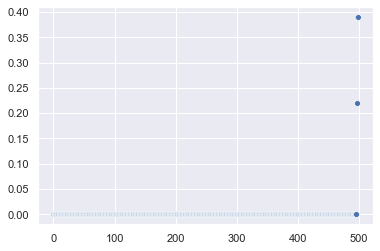

média: 0.002004008016032064
Atores mais importantes:


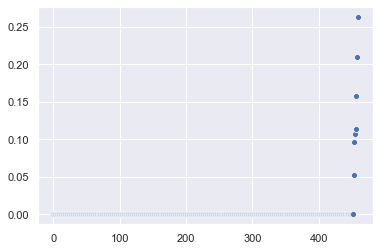

média: 0.002173913043478261
Atores mais importantes:


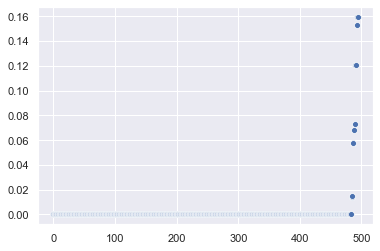

média: 0.00202020202020202
Atores mais importantes:


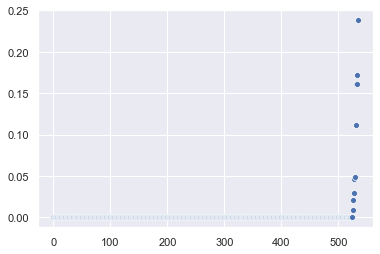

média: 0.0018691588785046734
Atores mais importantes:


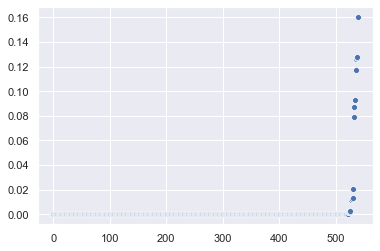

média: 0.0018518518518518521
Atores mais importantes:


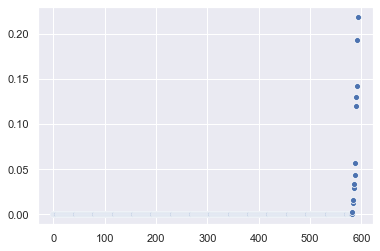

média: 0.0016835016835016836
Atores mais importantes:


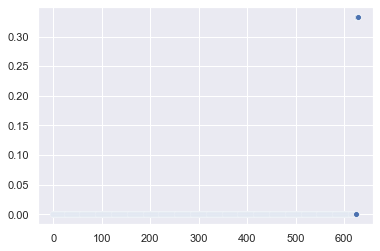

média: 0.0015898251192368843
Atores mais importantes:


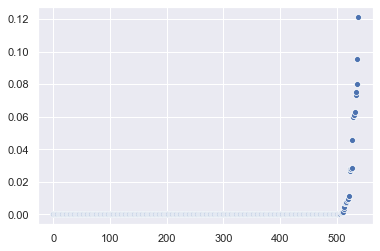

média: 0.001858736059479554
Atores mais importantes:


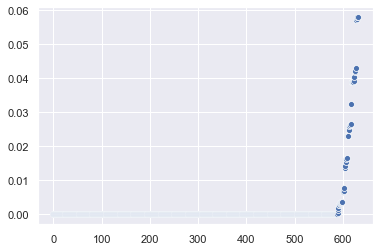

média: 0.001582278481012658
Atores mais importantes:


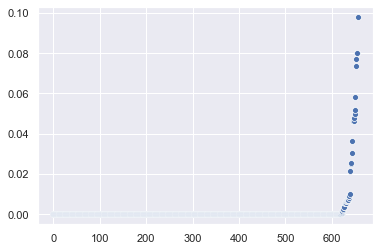

média: 0.0015220700152207003
Atores mais importantes:


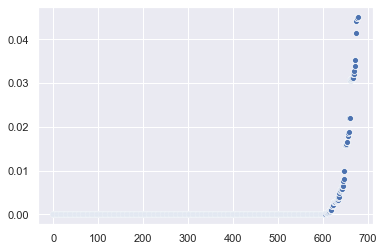

média: 0.0014727540500736379
Atores mais importantes:


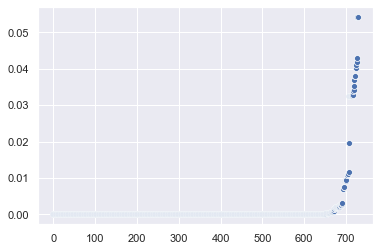

média: 0.0013717421124828536
Atores mais importantes:


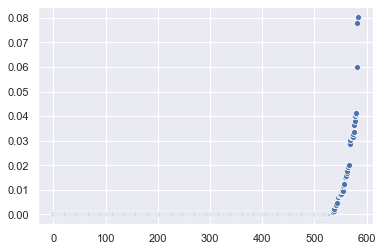

média: 0.0017123287671232874
Atores mais importantes:


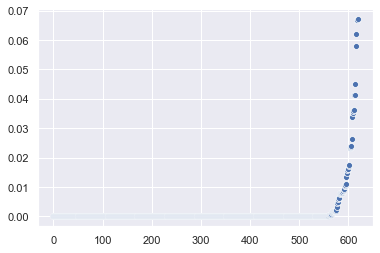

média: 0.0016129032258064518
Atores mais importantes:


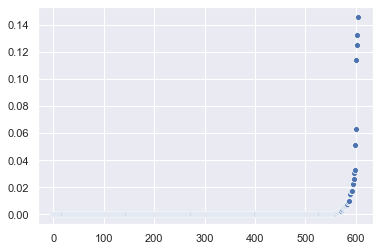

média: 0.0016528925619834715
Atores mais importantes:


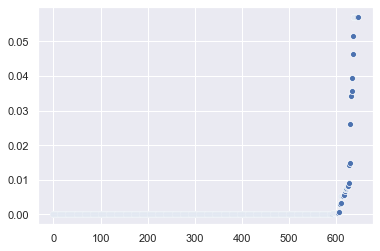

média: 0.0015455950540958266
Atores mais importantes:


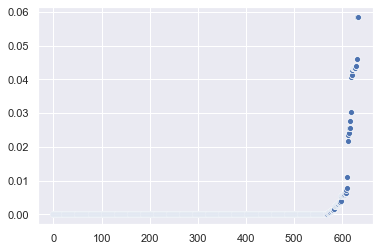

média: 0.0015797788309636653
Atores mais importantes:


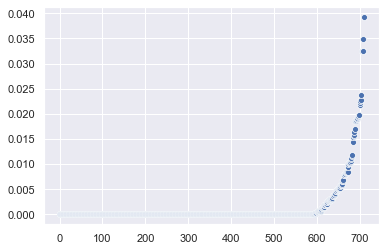

média: 0.0014084507042253518
Atores mais importantes:


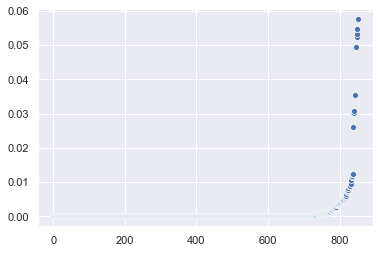

média: 0.0011737089201877937
Atores mais importantes:


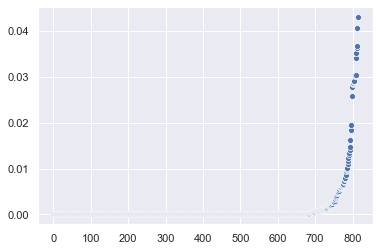

média: 0.0012269938650306747
Atores mais importantes:


In [60]:
for ano in range(2000,2020):
    basename="base{}.gml".format(ano)
    g = fm.load(basename)

    g.label_nodes()
    g.set_all_nodes(size=1, labpos='hover')
    g.set_all_edges(color=(0, 0, 0, 0.5))
    t1,t2 = nx.hits(g, max_iter=100000, tol=1e-06, nstart=None, normalized=True)
    def eigen(row):
        return t1[row["SongFiltred"]]
    
    df=dic_dataframe[ano].copy()
    df.apply (lambda row: eigen(row), axis=1)
    dic_dataframe[ano]=df
    
    bc_ck,bc_k,bc_v,bc_df=get_sorted_list_from_dict(t1)
    sns.scatterplot(bc_ck, bc_v);
    plt.show()

    print("média: {}".format(mean(bc_v)))
    print("Atores mais importantes:")


In [61]:
dic_dataframe[2000].columns

Index(['url', 'WeekID', 'Week Position', 'Song_x', 'Performer_x', 'SongID',
       'Instance', 'Previous Week Position', 'Peak Position', 'Weeks on Chart',
       'timestamp', 'Performer_y', 'Song_y', 'spotify_genre',
       'spotify_track_id', 'spotify_track_preview_url', 'spotify_track_album',
       'spotify_track_explicit', 'spotify_track_duration_ms',
       'spotify_track_popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'SongFiltred'],
      dtype='object')

In [36]:
for ano in range(2000,2020):
    genre="genre{}.gml".format(ano)
    with open(genre,"w") as content:
        content.writelines("graph [\n  directed 1\n")
        for i in range(len(lista_generos[ano])):
            line="  node [\n    id \"{}\"\n  ]\n".format(lista_generos[ano][i])
            content.writelines(line)
        for i in range(len(lista_musicas[ano])):
            line="  node [\n    id \"{}\"\n  ]\n".format(lista_musicas[ano][i])
            content.writelines(line)
        for i in range(len(lista_musicas_generos[ano])):
            line="  edge [\n    source \"{0}\"\n    target \"{1}\"\n    weight {2}\n  ]\n".format(lista_musicas_generos[ano][i][0],lista_musicas_generos[ano][i][1],1)
            content.writelines(line)
            line="  edge [\n    source \"{0}\"\n    target \"{1}\"\n    weight {2}\n  ]\n".format(lista_musicas_generos[ano][i][1],lista_musicas_generos[ano][i][0],1)
            content.writelines(line)
        content.writelines("]")

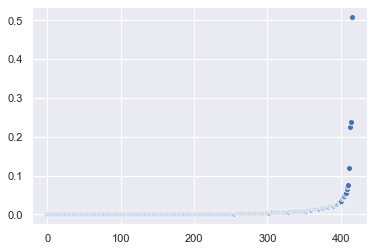

média: 0.007878671878148039
Atores mais importantes:
[('album rock', 0.0), ('art rock', 0.0), ('folk', 0.0), ('folk rock', 0.0), ('heartland rock', 0.0), ('roots rock', 0.0), ('singer-songwriter', 0.0), ('yacht rock', 0.0), ('wrestling', 0.0), ('indie r&b', 0.0), ('nc hip hop', 0.0), ('acoustic pop', 0.0), ('rap kreyol', 0.0), ('deep latin christian', 0.0), ('glam rock', 0.0), ('piano rock', 0.0), ('disco house', 0.0), ('vocal house', 0.0), ('canadian indie', 0.0), ('canadian rock', 0.0), ('eurodance', 0.0), ('industrial metal', 0.0), ('industrial rock', 0.0), ('gospel', 0.0), ('gospel r&b', 0.0), ('electropop', 0.0), ('outlaw country', 0.0), ('blues rock', 0.0), ('skate punk', 0.0), ('alberta country', 0.0), ('canadian contemporary country', 0.0), ('canadian country', 0.0), ('glam metal', 0.0), ('grunge pop', 0.0), ('dancehall', 0.0), ('soca', 0.0), ('bubblegum dance', 0.0), ('french pop', 0.0), ('operatic pop', 0.0), ('ccm', 0.0), ('christian alternative rock', 0.0), ('christian musi

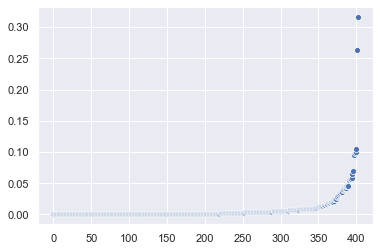

média: 0.007718534361724172
Atores mais importantes:
[('art rock', 0.0), ('post-metal', 0.0), ('progressive metal', 0.0), ('progressive rock', 0.0), ('electropop', 0.0), ('adult standards', 0.0), ('classic soul', 0.0), ('southern soul', 0.0), ('electro', 0.0), ('reggae fusion', 0.0), ('celtic', 0.0), ('middle earth', 0.0), ('piano rock', 0.0), ('big beat', 0.0), ('ninja', 0.0), ('trip hop', 0.0), ('glam metal', 0.0), ('indie soul', 0.0), ('neo r&b', 0.0), ('bounce', 0.0), ('art pop', 0.0), ('memphis hip hop', 0.0), ('deep contemporary country', 0.0), ('downtempo', 0.0), ('electronica', 0.0), ('nc hip hop', 0.0), ('bow pop', 0.0), ('celtic rock', 0.0), ('tropical', 0.0), ('hard rock', 0.0), ('lilith', 0.0), ('bubble trance', 0.0), ('tropical house', 0.0), ('canadian pop punk', 0.0), ('canadian punk', 0.0), ('finnish edm', 0.0), ('dance rock', 0.0), ('new romantic', 0.0), ('new wave', 0.0), ('synthpop', 0.0), ('alternative country', 0.0), ('folk', 0.0), ('indie folk', 0.0), ('new america

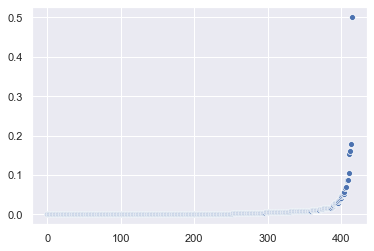

média: 0.007760980406166901
Atores mais importantes:
[('wrestling', 0.0), ('battle rap', 0.0), ('deep contemporary country', 0.0), ('big beat', 0.0), ('disco house', 0.0), ('adult standards', 0.0), ('contemporary vocal jazz', 0.0), ('vocal jazz', 0.0), ('australian country', 0.0), ('alaska indie', 0.0), ('progressive trance', 0.0), ('trance', 0.0), ('indie soul', 0.0), ('grupera', 0.0), ('punk', 0.0), ('socal pop punk', 0.0), ('canadian singer-songwriter', 0.0), ('reggae fusion', 0.0), ('soca', 0.0), ('country gospel', 0.0), ('south african rock', 0.0), ('outlaw country', 0.0), ('irish rock', 0.0), ('palm desert scene', 0.0), ('stoner metal', 0.0), ('stoner rock', 0.0), ('modern salsa', 0.0), ('salsa', 0.0), ('trap queen', 0.0), ('conscious hip hop', 0.0), ('motown', 0.0), ('dance-punk', 0.0), ('indie rock', 0.0), ('new rave', 0.0), ('swedish garage rock', 0.0), ('swedish hard rock', 0.0), ('swedish indie rock', 0.0), ('alabama metal', 0.0), ('turntablism', 0.0), ('new jersey rap', 0.0

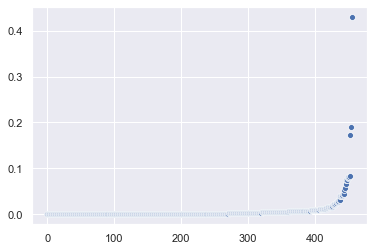

média: 0.006748381458559991
Atores mais importantes:
[('new jersey rap', 0.0), ('modern blues rock', 0.0), ('punk blues', 0.0), ('turntablism', 0.0), ('indie rock', 0.0), ('piano rock', 0.0), ('stomp and holler', 0.0), ('belgian dance', 0.0), ('belgian pop', 0.0), ('chicano rap', 0.0), ('latin hip hop', 0.0), ('old school hip hop', 0.0), ('christian rock', 0.0), ('industrial metal', 0.0), ('canadian indie', 0.0), ('bhangra', 0.0), ('desi hip hop', 0.0), ('desi pop', 0.0), ('miami hip hop', 0.0), ('rap latina', 0.0), ('country rap', 0.0), ('lgbtq+ hip hop', 0.0), ('downtempo', 0.0), ('electronica', 0.0), ('nu jazz', 0.0), ('trip hop', 0.0), ('screamo', 0.0), ('puerto rican pop', 0.0), ('texas pop punk', 0.0), ('alberta country', 0.0), ('canadian contemporary country', 0.0), ('art rock', 0.0), ('grunge', 0.0), ('hard rock', 0.0), ('alaska indie', 0.0), ('canadian singer-songwriter', 0.0), ('ectofolk', 0.0), ('socal pop punk', 0.0), ('lovers rock', 0.0), ('ccm', 0.0), ('christian alternat

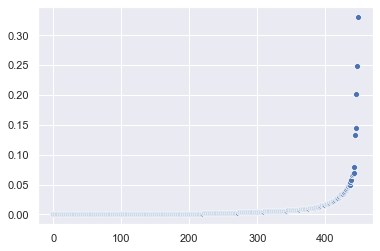

média: 0.00817539295803821
Atores mais importantes:
[('scottish rock', 0.0), ('indie soul', 0.0), ('talent show', 0.0), ('cali rap', 0.0), ('hyphy', 0.0), ('power pop', 0.0), ('uk garage', 0.0), ('barbadian pop', 0.0), ('chutney', 0.0), ('latin pop', 0.0), ('comic', 0.0), ('texas pop punk', 0.0), ('south african rock', 0.0), ('gospel r&b', 0.0), ('belgian dance', 0.0), ('belgian pop', 0.0), ('bow pop', 0.0), ('philly rap', 0.0), ('canadian singer-songwriter', 0.0), ('country pop', 0.0), ('british soul', 0.0), ('bluegrass', 0.0), ('folk rock', 0.0), ('roots rock', 0.0), ('traditional folk', 0.0), ('australian dance', 0.0), ('country rap', 0.0), ('lgbtq+ hip hop', 0.0), ('vocal house', 0.0), ('dance rock', 0.0), ('new romantic', 0.0), ('new wave', 0.0), ('synthpop', 0.0), ('azonto', 0.0), ('panamanian pop', 0.0), ('turntablism', 0.0), ('lo-fi', 0.0), ('washington indie', 0.0), ('deep vocal house', 0.0), ('alternative dance', 0.0), ('art pop', 0.0), ('vocal jazz', 0.0), ('bubblegum dance'

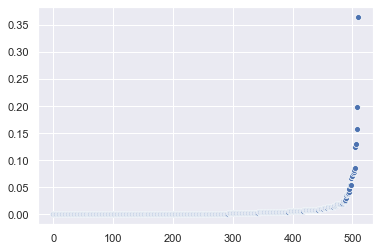

média: 0.006603098829680841
Atores mais importantes:
[('jam band', 0.0), ('ethiopian pop', 0.0), ('australian rock', 0.0), ('funk rock', 0.0), ('country gospel', 0.0), ('comic', 0.0), ('texas pop punk', 0.0), ('modern blues rock', 0.0), ('punk blues', 0.0), ('memphis hip hop', 0.0), ('alternative r&b', 0.0), ('san diego rap', 0.0), ('hollywood', 0.0), ('show tunes', 0.0), ('ccm', 0.0), ('worship', 0.0), ('singer-songwriter', 0.0), ('washington indie', 0.0), ('bounce', 0.0), ('latin arena pop', 0.0), ('scottish rock', 0.0), ('bluegrass gospel', 0.0), ('art pop', 0.0), ('neon pop punk', 0.0), ('pixie', 0.0), ('pop emo', 0.0), ('bubblegum dance', 0.0), ('german techno', 0.0), ('melbourne bounce international', 0.0), ('palm desert scene', 0.0), ('stoner metal', 0.0), ('stoner rock', 0.0), ('groove metal', 0.0), ('southern rock', 0.0), ('new orleans rap', 0.0), ('rap latina', 0.0), ('gospel', 0.0), ('gospel r&b', 0.0), ('canadian metal', 0.0), ('swedish alternative rock', 0.0), ('swedish in

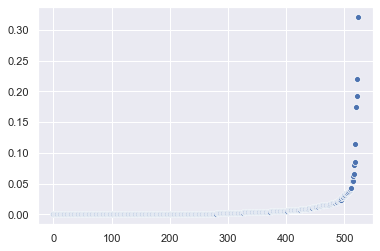

média: 0.007073510058470878
Atores mais importantes:
[('strut', 0.0), ('memphis hip hop', 0.0), ('canadian metal', 0.0), ('outlaw country', 0.0), ('bounce', 0.0), ('hard rock', 0.0), ('sleaze rock', 0.0), ('nc hip hop', 0.0), ('anthem worship', 0.0), ('ccm', 0.0), ('christian pop', 0.0), ('worship', 0.0), ('arkansas country', 0.0), ('british soul', 0.0), ('country gospel', 0.0), ('modern blues rock', 0.0), ('cyberpunk', 0.0), ('electronic rock', 0.0), ('industrial', 0.0), ('industrial metal', 0.0), ('industrial rock', 0.0), ('canadian singer-songwriter', 0.0), ('ectofolk', 0.0), ('alaska indie', 0.0), ('australian country', 0.0), ('bow pop', 0.0), ('lgbtq+ hip hop', 0.0), ('indie folk', 0.0), ('latin rock', 0.0), ('mexican rock', 0.0), ('chicago indie', 0.0), ('la pop', 0.0), ('transpop', 0.0), ('stomp and holler', 0.0), ('cumbia', 0.0), ('houston rap', 0.0), ('disco', 0.0), ('motown', 0.0), ('old school hip hop', 0.0), ('trap queen', 0.0), ('gospel r&b', 0.0), ('country pop', 0.0), ('

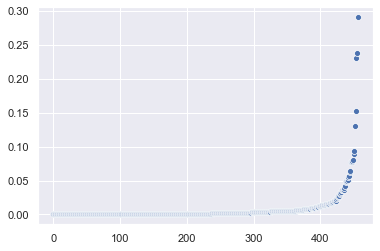

média: 0.007812579757759994
Atores mais importantes:
[('idol', 0.0), ('glam metal', 0.0), ('g funk', 0.0), ('west coast rap', 0.0), ('indie poptimism', 0.0), ('philly rap', 0.0), ('talent show', 0.0), ('alternative r&b', 0.0), ('wrestling', 0.0), ('chicano rap', 0.0), ('dance rock', 0.0), ('new wave', 0.0), ('bassline', 0.0), ('lo-fi', 0.0), ('washington indie', 0.0), ('cyberpunk', 0.0), ('electronic rock', 0.0), ('industrial', 0.0), ('industrial metal', 0.0), ('industrial rock', 0.0), ('kids dance party', 0.0), ('modern blues rock', 0.0), ('punk blues', 0.0), ('lounge', 0.0), ('soul', 0.0), ('show tunes', 0.0), ('country gospel', 0.0), ('detroit hip hop', 0.0), ('scottish rock', 0.0), ('texas country', 0.0), ('art pop', 0.0), ('experimental pop', 0.0), ('icelandic experimental', 0.0), ('icelandic pop', 0.0), ('metropopolis', 0.0), ('trip hop', 0.0), ('bronx hip hop', 0.0), ('hardcore hip hop', 0.0), ('electroclash', 0.0), ('indietronica', 0.0), ('new rave', 0.0), ('birmingham metal', 

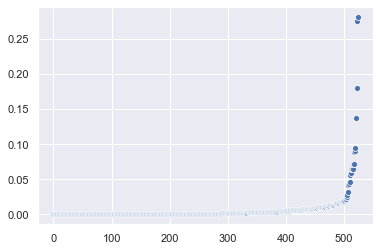

média: 0.006277918754383077
Atores mais importantes:
[('christian alternative rock', 0.0), ('christian rock', 0.0), ('canadian indie', 0.0), ('chamber pop', 0.0), ('slow core', 0.0), ('panamanian pop', 0.0), ('reggaeton', 0.0), ('escape room', 0.0), ('sleaze rock', 0.0), ('reggae fusion', 0.0), ('toronto rap', 0.0), ('rap kreyol', 0.0), ('harlem hip hop', 0.0), ('trap queen', 0.0), ('old school hip hop', 0.0), ('bassline', 0.0), ('g funk', 0.0), ('west coast rap', 0.0), ('art rock', 0.0), ('melancholia', 0.0), ('oxford indie', 0.0), ('miami bass', 0.0), ('dance-punk', 0.0), ('canadian metal', 0.0), ('wrestling', 0.0), ('social media pop', 0.0), ('blues rock', 0.0), ('garage rock', 0.0), ('modern blues rock', 0.0), ('punk blues', 0.0), ('indie poptimism', 0.0), ('folk', 0.0), ('baroque pop', 0.0), ('memphis hip hop', 0.0), ('swedish electropop', 0.0), ('swedish pop', 0.0), ('south african rock', 0.0), ('show tunes', 0.0), ('funk', 0.0), ('soul', 0.0), ('washington indie', 0.0), ('mexica

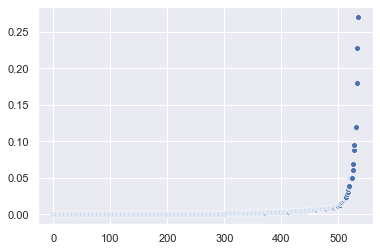

média: 0.005520369794284296
Atores mais importantes:
[('south african rock', 0.0), ('modern alternative rock', 0.0), ('funk', 0.0), ('soul', 0.0), ('arkansas country', 0.0), ('dancehall', 0.0), ('jam band', 0.0), ('indie pop rap', 0.0), ('punk blues', 0.0), ('adult standards', 0.0), ('lounge', 0.0), ('k-pop', 0.0), ('k-pop girl group', 0.0), ('bubblegum dance', 0.0), ('eurodance', 0.0), ('german techno', 0.0), ('melbourne bounce international', 0.0), ('alternative pop rock', 0.0), ('norwegian hip hop', 0.0), ('rap rock', 0.0), ('screamo', 0.0), ('comic', 0.0), ('new wave pop', 0.0), ('wrestling', 0.0), ('deep southern trap', 0.0), ('dfw rap', 0.0), ('art pop', 0.0), ('escape room', 0.0), ('anthem worship', 0.0), ('ccm', 0.0), ('worship', 0.0), ('la indie', 0.0), ('conscious hip hop', 0.0), ('lilith', 0.0), ('brooklyn indie', 0.0), ('shimmer pop', 0.0), ('charlottesville indie', 0.0), ('hard rock', 0.0), ('mellow gold', 0.0), ('ann arbor indie', 0.0), ('old school hip hop', 0.0), ('glam

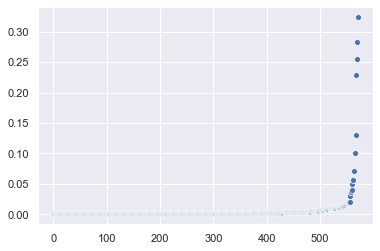

média: 0.00529883518638243
Atores mais importantes:
[('art pop', 0.0), ('baroque pop', 0.0), ('uk alternative pop', 0.0), ('hardcore hip hop', 0.0), ('australian country', 0.0), ('neo-synthpop', 0.0), ('romanian pop', 0.0), ('slow game', 0.0), ('west coast rap', 0.0), ('comic', 0.0), ('adult standards', 0.0), ('lounge', 0.0), ('canadian country', 0.0), ('canadian singer-songwriter', 0.0), ('folk', 0.0), ('mellow gold', 0.0), ('singer-songwriter', 0.0), ('indie rock', 0.0), ('groove metal', 0.0), ('puerto rican pop', 0.0), ('anthem worship', 0.0), ('ccm', 0.0), ('christian music', 0.0), ('christian pop', 0.0), ('boy band', 0.0), ('irish rock', 0.0), ('philly rap', 0.0), ('hard rock', 0.0), ('metropopolis', 0.0), ('dancehall', 0.0), ('lovers rock', 0.0), ('electronic rock', 0.0), ('modern folk rock', 0.0), ('stomp and holler', 0.0), ('uk americana', 0.0), ('alternative r&b', 0.0), ('rebel blues', 0.0), ('christian rock', 0.0), ('rap rock', 0.0), ('talent show', 0.0), ('canadian metal', 0

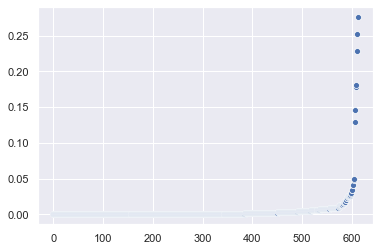

média: 0.004940068226762236
Atores mais importantes:
[('funk metal', 0.0), ('funk rock', 0.0), ('stomp pop', 0.0), ('deep big room', 0.0), ('dutch house', 0.0), ('progressive electro house', 0.0), ('south african rock', 0.0), ('country gospel', 0.0), ('heartland rock', 0.0), ('folk', 0.0), ('lilith', 0.0), ('new wave pop', 0.0), ('singer-songwriter', 0.0), ('pixie', 0.0), ('pop emo', 0.0), ('piano rock', 0.0), ('christian rock', 0.0), ('rap rock', 0.0), ('modern folk rock', 0.0), ('uk americana', 0.0), ('broadway', 0.0), ('alternative r&b', 0.0), ('lgbtq+ hip hop', 0.0), ('escape room', 0.0), ('rap metal', 0.0), ('chicago hardcore', 0.0), ('chicago punk', 0.0), ('hardcore punk', 0.0), ('filter house', 0.0), ('blues rock', 0.0), ('modern blues rock', 0.0), ('quiet storm', 0.0), ('romanian pop', 0.0), ('chicago house', 0.0), ('east coast hip hop', 0.0), ('indie poptimism', 0.0), ('easy listening', 0.0), ('vocal jazz', 0.0), ('teen pop', 0.0), ('funk', 0.0), ('soul', 0.0), ('disney', 0.0)

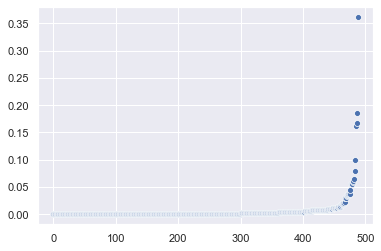

média: 0.005715982882030585
Atores mais importantes:
[('sertanejo', 0.0), ('sertanejo pop', 0.0), ('sertanejo universitario', 0.0), ('west coast rap', 0.0), ('alternative dance', 0.0), ('shimmer pop', 0.0), ('canadian hip hop', 0.0), ('toronto rap', 0.0), ('uk alternative pop', 0.0), ('neon pop punk', 0.0), ('pop punk', 0.0), ('trancecore', 0.0), ('singer-songwriter', 0.0), ('album rock', 0.0), ('classic rock', 0.0), ('hard rock', 0.0), ('metal', 0.0), ('crunk', 0.0), ('memphis hip hop', 0.0), ('deep southern trap', 0.0), ('idol', 0.0), ('irish rock', 0.0), ('dancehall', 0.0), ('drum and bass', 0.0), ('bronx hip hop', 0.0), ('hardcore hip hop', 0.0), ('k-hop', 0.0), ('k-pop', 0.0), ('disco house', 0.0), ('progressive electro house', 0.0), ('french shoegaze', 0.0), ('neo-synthpop', 0.0), ('celtic rock', 0.0), ('heartland rock', 0.0), ('latin pop', 0.0), ('mexican pop', 0.0), ('tropical', 0.0), ('jam band', 0.0), ('new americana', 0.0), ('alternative r&b', 0.0), ('lgbtq+ hip hop', 0.0), 

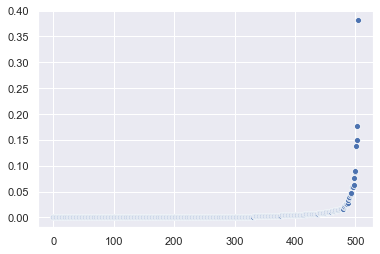

média: 0.005505392913616839
Atores mais importantes:
[('nz pop', 0.0), ('reggaeton', 0.0), ('pixie', 0.0), ('pittsburgh rap', 0.0), ('modern uplift', 0.0), ('modern alternative rock', 0.0), ('bass trap', 0.0), ('electronic trap', 0.0), ('vapor twitch', 0.0), ('shimmer pop', 0.0), ('reggae fusion', 0.0), ('electro', 0.0), ('filter house', 0.0), ('new orleans rap', 0.0), ('modern folk rock', 0.0), ('uk americana', 0.0), ('grunge', 0.0), ('cali rap', 0.0), ('swedish electropop', 0.0), ('swedish pop', 0.0), ('swedish synthpop', 0.0), ('heartland rock', 0.0), ('texas country', 0.0), ('moombahton', 0.0), ('idol', 0.0), ('queens hip hop', 0.0), ('nu metal', 0.0), ('ccm', 0.0), ('cedm', 0.0), ('christian alternative rock', 0.0), ('christian music', 0.0), ('christian pop', 0.0), ('worship', 0.0), ('alternative r&b', 0.0), ('trap queen', 0.0), ('neon pop punk', 0.0), ('adult standards', 0.0), ('lounge', 0.0), ('australian country', 0.0), ('deep big room', 0.0), ('dutch house', 0.0), ('progressiv

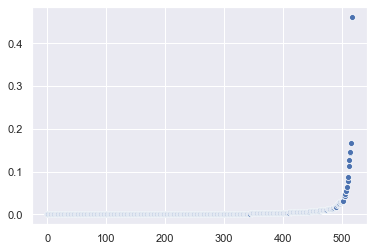

média: 0.005759303260540274
Atores mais importantes:
[('chicago rap', 0.0), ('south african rock', 0.0), ('new orleans rap', 0.0), ('sheffield indie', 0.0), ('latin viral pop', 0.0), ('rap latina', 0.0), ('uk funky', 0.0), ('girl group', 0.0), ('europop', 0.0), ('australian dance', 0.0), ('pixie', 0.0), ('pop emo', 0.0), ('german pop', 0.0), ('atl trap', 0.0), ('irish singer-songwriter', 0.0), ('canadian hip hop', 0.0), ('toronto rap', 0.0), ('outlaw country', 0.0), ('k-hop', 0.0), ('k-pop', 0.0), ('comedy', 0.0), ('a cappella', 0.0), ('west coast rap', 0.0), ('bachata', 0.0), ('teen pop', 0.0), ('canadian indie', 0.0), ('indietronica', 0.0), ('swedish electropop', 0.0), ('swedish pop', 0.0), ('swedish synthpop', 0.0), ('chicago indie', 0.0), ('dance-punk', 0.0), ('blues rock', 0.0), ('punk blues', 0.0), ('celtic rock', 0.0), ('adult standards', 0.0), ('brill building pop', 0.0), ('bubblegum pop', 0.0), ('classic country pop', 0.0), ('classic uk pop', 0.0), ('country rock', 0.0), ('fol

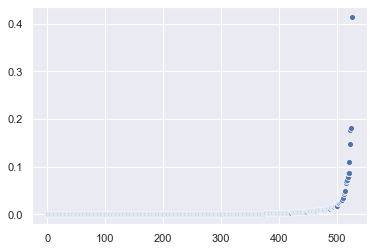

média: 0.005577494806589511
Atores mais importantes:
[('modern folk rock', 0.0), ('uk americana', 0.0), ('neo-singer-songwriter', 0.0), ('hardcore hip hop', 0.0), ('old school hip hop', 0.0), ('australian country', 0.0), ('nc hip hop', 0.0), ('stomp pop', 0.0), ('swedish electropop', 0.0), ('swedish pop', 0.0), ('swedish synthpop', 0.0), ('ghanaian hip hop', 0.0), ('houston rap', 0.0), ('progressive house', 0.0), ('hopebeat', 0.0), ('indietronica', 0.0), ('irish rock', 0.0), ('irish singer-songwriter', 0.0), ('singer-songwriter', 0.0), ('latin hip hop', 0.0), ('big room', 0.0), ('gospel r&b', 0.0), ('virgin islands reggae', 0.0), ('new orleans rap', 0.0), ('memphis hip hop', 0.0), ('nu-metalcore', 0.0), ('uk contemporary r&b', 0.0), ('nyc rap', 0.0), ('underground hip hop', 0.0), ('downtempo', 0.0), ('shiver pop', 0.0), ('k-hop', 0.0), ('k-pop', 0.0), ('latin viral pop', 0.0), ('rap latina', 0.0), ('liquid funk', 0.0), ('uk funky', 0.0), ('folk', 0.0), ('lilith', 0.0), ('mellow gold', 

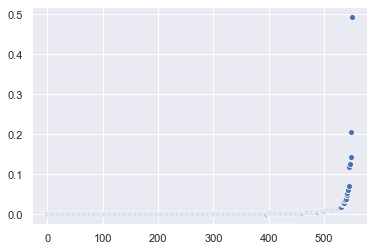

média: 0.004922919354504249
Atores mais importantes:
[('drill', 0.0), ('san diego rap', 0.0), ('australian hip hop', 0.0), ('pittsburgh rap', 0.0), ('nyc rap', 0.0), ('deep euro house', 0.0), ('deep house', 0.0), ('german dance', 0.0), ('modern southern rock', 0.0), ('alternative rock', 0.0), ('funk metal', 0.0), ('funk rock', 0.0), ('brostep', 0.0), ('electro', 0.0), ('nyc pop', 0.0), ('bronx hip hop', 0.0), ('a cappella', 0.0), ('disney', 0.0), ('hollywood', 0.0), ('movie tunes', 0.0), ('show tunes', 0.0), ('europop', 0.0), ('canadian folk', 0.0), ('canadian singer-songwriter', 0.0), ('folk', 0.0), ('folk rock', 0.0), ('melancholia', 0.0), ('swedish synthpop', 0.0), ('folk-pop', 0.0), ('stomp and holler', 0.0), ('boy band', 0.0), ('indie electropop', 0.0), ('la pop', 0.0), ('pop edm', 0.0), ('bow pop', 0.0), ('memphis hip hop', 0.0), ('la indie', 0.0), ('deep talent show', 0.0), ('k-pop', 0.0), ('champeta', 0.0), ('vallenato', 0.0), ('pop punk', 0.0), ('punk', 0.0), ('socal pop punk'

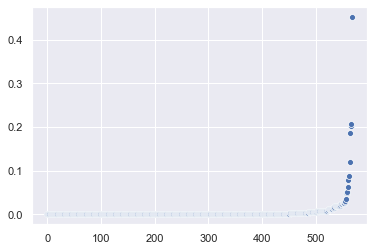

média: 0.004762521383152116
Atores mais importantes:
[('hollywood', 0.0), ('show tunes', 0.0), ('brostep', 0.0), ('progressive electro house', 0.0), ('aussietronica', 0.0), ('arkansas country', 0.0), ('american folk revival', 0.0), ('uk funky', 0.0), ('portland hip hop', 0.0), ('canadian contemporary r&b', 0.0), ('girl group', 0.0), ('brill building pop', 0.0), ('easy listening', 0.0), ('mellow gold', 0.0), ('new wave pop', 0.0), ('alternative metal', 0.0), ('nu metal', 0.0), ('post-grunge', 0.0), ('rap metal', 0.0), ('big room', 0.0), ('australian country', 0.0), ('australian dance', 0.0), ('nc hip hop', 0.0), ('trap latino', 0.0), ('detroit trap', 0.0), ('hawaiian hip hop', 0.0), ('reggaeton flow', 0.0), ('indie rock', 0.0), ('candy pop', 0.0), ('emo', 0.0), ('pop emo', 0.0), ('pop punk', 0.0), ('hyphy', 0.0), ('pop edm', 0.0), ('viral trap', 0.0), ('pittsburgh rap', 0.0), ('indie folk', 0.0), ('new americana', 0.0), ('stomp and holler', 0.0), ('cali rap', 0.0), ('neo-traditional cou

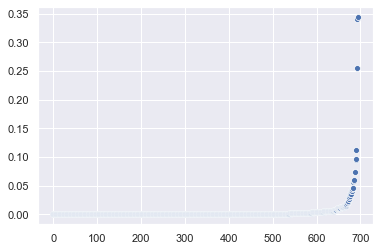

média: 0.0042042730948666715
Atores mais importantes:
[('electronic trap', 0.0), ('alternative rock', 0.0), ('permanent wave', 0.0), ('alabama rap', 0.0), ('classic girl group', 0.0), ('cowboy western', 0.0), ('traditional country', 0.0), ('yodeling', 0.0), ('lounge', 0.0), ('singer-songwriter', 0.0), ('lgbtq+ hip hop', 0.0), ('candy pop', 0.0), ('chinese hip hop', 0.0), ('chinese idol pop', 0.0), ('australian pop', 0.0), ('latin arena pop', 0.0), ('social media pop', 0.0), ('alberta country', 0.0), ('canadian contemporary country', 0.0), ('canadian country', 0.0), ('indie pop rap', 0.0), ('latin hip hop', 0.0), ('alternative hip hop', 0.0), ('art pop', 0.0), ('movie tunes', 0.0), ('trance', 0.0), ('israeli pop', 0.0), ('acoustic pop', 0.0), ('country rock', 0.0), ('boston hip hop', 0.0), ('texas country', 0.0), ('broadway', 0.0), ('dirty south rap', 0.0), ('outlaw country', 0.0), ('escape room', 0.0), ('heartland rock', 0.0), ('album rock', 0.0), ('classic rock', 0.0), ('folk rock', 0

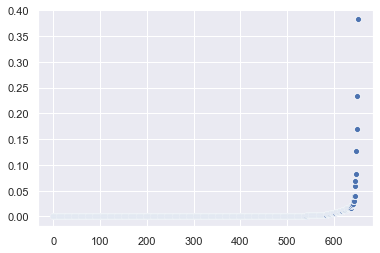

média: 0.003285720809963834
Atores mais importantes:
[('cartoon', 0.0), ('childrens music', 0.0), ('nyc rap', 0.0), ('uk contemporary r&b', 0.0), ('rock-and-roll', 0.0), ('rockabilly', 0.0), ('art pop', 0.0), ('australian hip hop', 0.0), ('groove metal', 0.0), ('queens hip hop', 0.0), ('destroy techno', 0.0), ('k-pop girl group', 0.0), ('brill building pop', 0.0), ('mellow gold', 0.0), ('lounge', 0.0), ('boston hip hop', 0.0), ('arkansas country', 0.0), ('k-hop', 0.0), ('house', 0.0), ('heartland rock', 0.0), ('danish pop', 0.0), ('metropopolis', 0.0), ('redneck', 0.0), ('social media pop', 0.0), ('rap latina', 0.0), ('alternative rock', 0.0), ('art rock', 0.0), ('post-metal', 0.0), ('progressive metal', 0.0), ('progressive rock', 0.0), ('rock', 0.0), ('neo mellow', 0.0), ('singer-songwriter', 0.0), ('anthem worship', 0.0), ('ccm', 0.0), ('christian alternative rock', 0.0), ('christian indie', 0.0), ('christian music', 0.0), ('world worship', 0.0), ('worship', 0.0), ('bachata', 0.0), (

In [57]:
for ano in range(2000,2020):
    genre="genre{}.gml".format(ano)
    g = fm.load(genre)

    g.label_nodes()
    g.set_all_nodes(size=1, labpos='hover')
    g.set_all_edges(color=(0, 0, 0, 0.5))
    t1= nx.betweenness_centrality(g, normalized=True)
    

    
    bc_ck,bc_k,bc_v,bc_df=get_sorted_list_from_dict(t1)
    
    sns.scatterplot(bc_ck, bc_v);
    plt.show()

    print("média: {}".format(mean(bc_v)))
    print("Atores mais importantes:")
    print(bc_df)

In [43]:
h = fm.load('genre2000.gml')

h.label_nodes()
h.set_all_nodes(size=1, labpos='hover')
h.set_all_edges(color=(0, 0, 0, 0.5))

h.interact()

***Seção de Métrica***

In [40]:
lista_generos.keys()

dict_keys([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

***Seção de Teste de Hipótese***

In [41]:
def eigen(row):
    return t1[row["SongFiltred"]]

In [ ]:
model = sm.OLS(data2000['loginv'], data2000[['eigen','danceability',
       'energy', 'loudness', 'speechiness', 'acousticness']])
result = model.fit()
result.summary()

In [ ]:
dataeigen = data2000.sort_values(by=['eigen'])

In [ ]:
lista_generos=[]
for i in data2000.index:
    
    gen= conv_string_to_list(data2000["spotify_genre"][i])
    
    for j in range(len(gen)):
        if gen[j] not in lista_generos:
            lista_generos.append(gen[j])
            
lista_musicas_generos=[]

for i in data2000.index:
    insertfeat(lista_musicas_generos,gen,data2000["SongFiltred"][i])

In [ ]:
u1 = nx.betweenness_centrality(h)
bc_ck,bc_k,bc_v=get_sorted_list_from_dict(u1)
sns.scatterplot(bc_ck, bc_v);

print("média: {}".format(mean(bc_v)))
print("Atores mais importantes:")

In [ ]:
# def plotcalor(nome):
#     xv=7
#     yv=6
#     dx=max(dataeigen["eigen"])/xv
#     dy=max(dataeigen[nome])/yv
    
#     heatmap=np.array([[0.0]*xv]*xv)
#     for i in range(xv):
#         cat=0
        
#         lista=[0]*xv
#         for j in dataeigen.index:
#             if (dataeigen["eigen"][j]<(dx*i+dx) and dataeigen["eigen"][j]>(dx*i)):
#                 cat+=1 
        
#         for j in dataeigen.index:
#             for k in range(xv):
#                 if (dataeigen["eigen"][j]<=(dx*i+dx) and dataeigen["eigen"][j]>(dx*i)):
#                     if (dataeigen[nome][j]<=(dy*k+dy) and dataeigen[nome][j]>(dy*k)):
#                         lista[k]+=1/cat
#         for j in range(len(lista)):
            
#             heatmap[xv-j-1][i]=lista[j]
            
#     print(heatmap)
#     fig, ax = plt.subplots()
#     im = ax.imshow(heatmap)
#     fig.tight_layout()
#     plt.show()